In [18]:
%mkdir '/data/MBDU/midla/notebooks/campcc/alt_rs_conn/basc/'

In [1]:
#quickstart
from pathlib import Path
import pandas as pd
from bids import BIDSLayout
from joblib import Parallel, delayed
import nilearn
import nibabel as nib
import nltools.prefs as prf
from nilearn import datasets, image, plotting, input_data
from nilearn.masking import apply_mask
from nilearn.image import resample_to_img
from nilearn.image import concat_imgs, index_img
import numpy as np
import matplotlib.pylab as plt

import os
import glob
import seaborn as sns
from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import zscore
from scipy.stats import binom, ttest_1samp
from sklearn.metrics import pairwise_distances
from nltools.stats import fdr, one_sample_permutation
from copy import deepcopy
from nltools.utils import get_anatomical
import nltools.plotting as nlplt
from datetime import date
from joblib import Parallel, delayed

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

from nilearn.input_data import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure

dat_paths = pd.read_csv('/data/MBDU/midla/notebooks/campcc/dat_paths_11272019.csv') 
atlas = image.load_img('/data/MBDU/midla/notebooks/campcc/hox_msdl_atlas.nii.gz')
#sub1 = image.load_img('/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-20900/out/fmrip

%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.width', 1000)

from IPython.core.display import display, HTML
display(HTML("<style>"
    + "#notebook { padding-top:0px !important; } " 
    + ".container { width:100% !important; } "
    + ".end_space { min-height:0px !important; } "
    + "</style>"))

/gpfs/gsfs11/users/MBDU/midla/env/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [18]:
msdl = datasets.fetch_atlas_msdl()
#msdl_coords = msdl_data.region_coords
resample_msdl = resample_to_img(msdl.maps,regions_extracted_img, interpolation="nearest")

/gpfs/gsfs11/users/MBDU/midla/env/lib/python3.7/site-packages/numpy/lib/npyio.py:2322: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [14]:
basc = datasets.fetch_atlas_basc_multiscale_2015(version='asym')
basc64 = basc['scale064']

In [20]:
resample_msdl = resample_to_img(msdl.maps,regions_extracted_img, interpolation="nearest")

AttributeError: 'str' object has no attribute 'shape'

In [11]:
msdl_bin = resample_msdl.get_fdata() > 0
rois_bin = regions_extracted_img.get_fdata() > 0

In [12]:
mask = msdl_bin[:,:,:,0] * rois_bin[:,:,:,0]
np.sum(rois_bin[:,:,:,0])
np.sum(mask)

IndexError: too many indices for array

In [9]:
msdl_networks = msdl.networks
rois = pd.read_csv('/data/MBDU/midla/notebooks/campcc/atlas_labels.csv', header=None).values.tolist()

In [176]:
rois[49][0]

'Right_Postcentral_Gyrus'

In [13]:
msdl_dict = {}
label_order = []
ua = []
ua.extend(range(49))
for x in range(38):
    for y in range(49):
        print(y)
        init = np.sum(rois_bin[:,:,:,y])
        mask = msdl_bin[:,:,:,x] * rois_bin[:,:,:,y]
        if (np.sum(mask) == init):
            label_order.append(y)
            ua.remove(y)
            if msdl_networks[x] in msdl_dict:
                msdl_dict[msdl_networks[x]].append(rois[y][0])
            else:
                msdl_dict[msdl_networks[x]] = rois[y]
                
for x in ua:
    label_order.append(x)

0


IndexError: too many indices for array

In [218]:
len(label_order)

49

In [190]:
mask = msdl_bin[:,:,:,x] * rois_bin[:,:,:,y]
np.sum(mask)

0

In [198]:
import csv
w = csv.writer(open("/data/MBDU/midla/notebooks/campcc/roi_networks.csv","w"))
for key, val in msdl_dict.items():
    w.writerow([key,val])

In [8]:
regions_extracted_img = image.load_img(basc64)

In [26]:
labels = pd.read_csv('/data/MBDU/midla/notebooks/campcc/atlas_labels.csv',header = None)

In [27]:
for _,row in dat_paths.iterrows():
    break
    
img = image.load_img(row.scaled_path)
regions_extracted_img = resample_to_img(regions_extracted_img,img)

In [28]:
#Function: takes in row and masker object
#Returns image masked by grey matter, confounds, and transformed to atlas masker
def gm_weight_and_mask(row, min_trs=100, **kwargs):
    img = image.load_img(row.scaled_path)
    img_dat = img.get_fdata()
    if img_dat.shape[-1] < min_trs:
        return None
    
    # load subjects grey matter mask
    mask_img = resample_to_img(image.load_img(row.mask_path),img)
    mask_dat = mask_img.get_fdata()[:,:,:,np.newaxis]
    mask_bin = mask_dat > 0
    
    regions_masked_dat = regions_extracted_img.get_fdata() * mask_bin[:,:,:,0]
    regions_masked_img = image.new_img_like(regions_extracted_img, 
                                            regions_masked_dat, 
                                            affine=regions_extracted_img.affine, 
                                            copy_header=True)
    
    gm_dat = mask_dat * (img_dat - 100)
    simple_masked_ts = np.zeros((img_dat.shape[-1], regions_masked_dat.shape[-1]))
    
    for yi in range(len(labels)):
        simple_masked_ts[:,yi] = (((gm_dat * regions_masked_dat[:,:,:,yi][:,:,:,np.newaxis]).sum(0).sum(0).sum(0))/regions_masked_dat[:,:,:,yi].sum() + 100)
    pd.DataFrame(simple_masked_ts).to_csv("/data/MBDU/midla/notebooks/campcc/alt_rs_conn/basc/basc_ts_subject_{}_session_{}_run_{}_task_{}.csv".format(row.subject,row.session,row.run,row.task),header=None, index=None)
    del img, img_dat, mask_img, mask_dat, gm_dat

In [21]:
for _,row in dat_paths.iterrows():
    break

In [ ]:
subject = gm_weight_and_mask(row, detrend=False,memory='nilearn_cache', memory_level=1)

In [90]:
subject_ts = Parallel(n_jobs=10, verbose=10)(delayed(gm_weight_and_mask)(row, detrend=False, memory='nilearn_cache', memory_level=1) for _, row in dat_paths.iterrows())

[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:  5.7min
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed: 11.1min
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed: 13.8min
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 17.7min
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed: 23.3min
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed: 33.4min
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed: 39.2min
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed: 46.1min
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed: 56.5min
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed: 63.5min
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed: 74.1min
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed: 82.2min
[Parallel(n_jobs=10)]: Done 161 tasks      | elapsed: 93.7min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed: 104.3min
[Parallel(n_jobs=10)]: Done 201 tasks      | elapsed: 117.7min
[Parallel(n_jobs=10)]: Done 222 tasks      | elapsed: 129.4min
[Para

In [45]:
img_dat = img.get_fdata()

In [91]:
subject = pd.read_csv("/data/MBDU/midla/notebooks/campcc/alt_rs_conn/ts_subject_{}_session_{}_run_{}_task_{}.csv".format(row.subject,row.session,row.run,row.task),header=None)

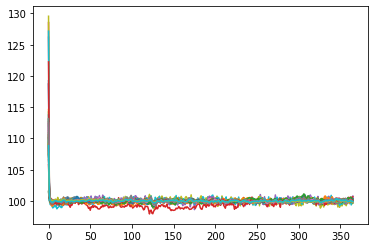

In [92]:
plt.plot(subject)

In [12]:
fnames = []
for _,row in dat_paths.iterrows():
    if os.path.isfile('/data/MBDU/midla/notebooks/campcc/alt_rs_conn/ts_subject_{}_session_{}_run_{}_task_{}.csv'.format(row.subject,row.session,row.run,row.task)):
        fnames.append('/data/MBDU/midla/notebooks/campcc/alt_rs_conn/ts_subject_{}_session_{}_run_{}_task_{}.csv'.format(row.subject,row.session,row.run,row.task))

In [20]:
dat_paths['alt_ts_path'] = fnames

In [17]:
dat_paths.to_csv("/data/MBDU/midla/notebooks/campcc/dat_paths_12092019.csv".format(row.subject,row.session,row.run,row.task))

In [27]:
def formatter(filepath):
    return np.array(pd.read_csv(filepath,header=None))

In [69]:
X = np.array(pd.read_csv(row.alt_rs_path,header=None))

In [66]:
pd.DataFrame(X)

0           1           2           3           4           5           6           7           8           9          10          11          12          13          14          15          16          17          18          19          20          21          22          23          24          25          26          27          28          29          30          31          32          33          34          35          36          37          38          39          40          41          42          43          44          45          46          47          48          49
0    124.296534  111.233999  101.186606  120.962119  127.534539  120.392488  106.555827  100.900918  120.076184  124.154528  110.837456  112.242595  115.072648  112.459250  115.605018  119.017717  111.406386  112.247505  111.353944  113.484524  111.500676  113.689822  112.031621  112.643678  110.741386  112.993193  110.734246  112.342483  112.248883  110.967057  109.109153  117.218478  111.643761  109.918121  114.427264  110.357570  116.226640  115.303361  113.432187  111.759792  114.294150  111.794528  114.363269  119.318850  113.641902  115.386585  115.134941  118.029628  109.524015  110.252115
1    101.381935  100.606597  100.039537  100.458581  100.625191  101.658260  100.438002  100.056908  100.703150  101.229056  101.325886  101.602806  101.691397  101.516012  101.690116  101.719887  101.835183  102.106868  101.236688  101.515227  101.322342  101.553598  101.771066  101.544076  100.706016  101.675656  101.210731  101.711233  101.503457  101.340852  101.109594  102.540732  101.918299  101.104398  100.971944  101.170963  101.488119  101.946631  101.814913  101.363650  101.240267  101.675453  102.152263  101.335018  101.750255  101.199374  100.927163  101.705466  101.053976  101.325031
2    100.278618   99.989935  100.008316   99.938898  100.351678  100.333466  100.064719  100.011110  100.184994  100.537806  100.108732  100.157461  100.340712  100.457849  100.754933  100.597485  100.446147  100.790210  100.226076  100.543934  100.124911  100.119874  100.337610  100.015454  100.105699  100.499246  100.274898  100.345995  100.474459  100.295797  100.174297  101.108819  100.717151  100.245191  100.271511  100.236713  100.292038  100.626204  100.458268  100.109127  100.306600  100.145918  100.484714  100.184043  100.605816  100.122970  100.121840  100.310710  100.214201  100.277409
3     99.641738   99.816623   99.982115   99.597701   99.678582  100.010524   99.935093  100.000706   99.818824  100.356965   99.727424   99.789593   99.779968  100.024262  100.245144  100.149008  100.067155  100.180854   99.882394  100.065259   99.843558   99.635503   99.885165   99.650094   99.898135   99.983783   99.983958   99.811793   99.996740  100.001769   99.835078  100.320692  100.151927  100.089739   99.995746   99.997880   99.784519  100.158892  100.180780   99.843032   99.879948   99.999273  100.026184   99.708410  100.130436   99.951973   99.681741   99.972451   99.863893   99.991547
4     99.654134   99.818048   99.972121   99.829051   99.707368   99.684993   99.925289   99.991992   99.685515   99.576611   99.922307   99.946204  100.205108  100.145992  100.330263   99.992788  100.192909  100.171009  100.075981  100.127722  100.049178   99.702442  100.204860   99.727287   99.830283  100.212774  100.077031   99.795093  100.177161  100.194918  100.092897  100.467637  100.381137  100.095493   99.912716  100.069899   99.892045  100.135021  100.345394   99.860083   99.825937  100.220415  100.090173   99.793300  100.248502   99.774999   99.783282   99.903880  100.004777  100.127346
5     99.428452   99.697735   99.957338   99.757392   99.521695   99.458543   99.870733   99.975771   99.901042   99.777467   99.866448   99.893482   99.958473  100.037020  100.133685   99.856528  100.114017   99.910163  100.006531  100.133452   99.997409   99.750744  100.193387   99.445864   99.734280  100.106357   99.994965   99.924616  100.106698  100.121415  100.006887  100.318960  1

In [67]:
Y = np.array(pd.read_csv(dat_paths.alt_rs_path[0],header = None))
dat_paths.alt_rs_path[0]
pd.DataFrame(Y)

0           1           2           3           4           5           6           7           8           9          10          11          12          13          14          15          16          17          18          19          20          21          22          23          24          25          26          27          28          29          30          31          32          33          34          35          36          37          38          39          40          41          42          43          44          45          46          47          48          49
0    119.224564  113.085775  101.558256  128.538453  126.201705  118.750790  110.658548  101.430906  129.548762  127.157657  107.967433  109.052154  114.230324  108.376479  118.649391  109.328085  111.519938  110.305925  109.445629  113.035036  108.617750  110.469479  110.059865  111.264006  110.114318  108.721561  108.814159  107.587538  108.994902  109.595106  107.453057  114.625095  110.594801  105.800282  109.067073  106.569632  112.367338  112.329185  109.132985  108.867910  113.754048  109.112843  110.921301  122.247104  111.978819  112.651965  112.474711  113.171302  107.596256  108.847611
1    101.028620  100.846849  100.064189  100.788190  100.325902  100.920379  100.604685  100.088000  101.001890   99.990586  100.857163  100.709249  101.019667  101.083503  101.469269  100.886594  100.993613  101.031087  101.079871  101.268922  100.865929  101.079877  100.920799  100.996080  100.612939  101.024231  101.061065  100.933805  100.822762  100.680298  100.644407  100.705927  100.472741  100.711328  100.731139  100.801314  101.316638  101.172115  101.165715  101.140198  101.325672  100.835587  101.374917  100.528864  101.074626  101.116805  101.013664  101.109818  100.799408  100.672854
2    100.514395  100.186982  100.006564  100.168384  100.045029  100.284591   99.970606  100.009250  100.359680   99.418936  100.315721  100.069783  100.147953  100.319609  100.494297  100.142623  100.113674  100.004367  100.270403  100.294002  100.128686  100.102917  100.287490  100.593508  100.223434  100.428412  100.293651  100.293676  100.307318  100.225310  100.009473   99.744056   99.858140  100.229485  100.154621  100.222020  100.386818  100.329769  100.362931  100.252833  100.201394  100.151608  100.108332  100.052875  100.371806  100.052037  100.163433  100.013148  100.238990  100.043609
3     99.975887   99.896234   99.988823  100.295071   99.730701   99.480464   99.752417   99.990953  100.105270   99.369774  100.061221   99.855264   99.779614  100.301913  100.278248   99.964197   99.921393   99.696816  100.027186  100.029609  100.078964   99.808864  100.159401  100.278616   99.911200  100.262210  100.232020  100.147834  100.045904  100.066595   99.813425   99.415475   99.610435  100.090181   99.976707  100.073672  100.094330  100.001602  100.116850  100.019327   99.997646   99.933758   99.853727   99.694215  100.082705   99.722357   99.810132   99.647987  100.021901   99.904767
4     99.916267   99.800150   99.965365   99.853521  100.000307   99.582988   99.821812  100.004848   99.717944   99.271571  100.009073   99.766406   99.622739  100.210805  100.167718   99.874936   99.923817   99.488033  100.014958   99.961114   99.912718   99.801033  100.078744  100.227084   99.867873  100.186404  100.145604  100.119655   99.986196  100.000440   99.715857   99.199724   99.561834  100.055674   99.863162   99.986372   99.864849   99.704106  100.103699  100.012278   99.780405   99.899156   99.764038   99.441623   99.896171   99.632371   99.717304   99.499218  100.021778   99.819256
5     99.779723   99.935437   99.964278   99.806335   99.495949   99.638391   99.873979  100.014554  100.098207   98.896446   99.999416   99.768206   99.598653  100.104203   99.892262   99.767805   99.834526   99.541401  100.057214  100.054301   99.857882   99.960038  100.021994  100.218661   99.910182  100.094747  100.048743  100.123098   99.962264   99.889661   99.804631   99.183793   

In [65]:
Z = np.array(pd.read_csv(dat_paths.alt_rs_path[7],header = None))
dat_paths.alt_rs_path[7]
pd.DataFrame(Z)

0           1           2           3           4           5           6           7           8           9          10          11          12          13          14          15          16          17          18          19          20          21          22          23          24          25          26          27          28          29          30          31          32          33          34          35          36          37          38          39          40          41          42          43          44          45          46          47          48          49
0    113.224535  108.280337  100.983115  115.928466  127.639557  110.646214  105.648581  100.693649  122.183446  123.973273  106.846860  105.696325  112.618639  106.514992  117.078226  105.856785  111.910992  109.554550  108.080657  110.865226  106.274942  105.434758  110.049767  111.191582  106.144937  107.460897  107.669812  104.904819  106.615156  109.001702  105.501673  113.691102  109.282287  103.525570  106.419092  103.426933  111.764142  108.923921  108.918738  107.418979  109.289826  109.952853  104.817710  120.550593  110.801973  110.052724  109.287658  108.129311  106.718055  107.555756
1    106.878794  102.886165  100.089698   99.332128  111.846447  107.849506  102.814094  100.178612  111.839294  121.201353  100.718900  101.655800  100.032250   99.825925  100.084817  103.263597  101.264226   99.009853  100.386739  101.098487  102.299042  103.158917  100.791778  107.208345  102.224786   99.392246  102.359470  106.990168   99.257108  100.276056   99.366623   98.626873   99.709115  101.764051  103.916894  101.615039  101.347764  102.323750  101.072102  102.785423  104.451165  102.498063  103.559298  100.686049   99.874383  102.183983  103.075003  101.471412   99.952058  101.444124
2    100.531417   99.189108   99.984943   95.729242  101.126419  102.618545  101.114628  100.028504  102.812113  106.361481   99.994420  100.372696   99.923439   98.944639   99.364279  101.334457   99.876567  100.234822   99.749895   99.839376  101.030627  104.379053  100.202032  103.404026  100.134147   98.786574  100.421831  102.525191   98.995284   99.710449   99.486566  100.196029   99.716441   99.849054  100.801560  100.920817  100.636017  100.868747  100.349901  100.871813  100.907766  101.167863  103.299784  100.314279   99.648013  100.439726  100.569139  100.930804   99.596878  100.503639
3     98.331279   98.098493   99.894162   93.881550   91.878072  100.293552  100.156404   99.989932   97.728675   97.299287   99.946645   99.793788   99.840414   98.950930   99.266192   99.912093   99.486514  100.458857   99.520692   99.798465  100.408029  101.281432   99.919844  101.932673   99.509995   98.740046  100.314376  101.120158   99.033905   99.662674   99.443528  100.026887   99.832526   99.743856  100.017692   99.975634  100.268705  100.168962  100.044026  100.412210  100.405643  100.594150  100.743438  100.237008   99.600324  100.094726  100.319542   99.374369   99.618301  100.201350
4     98.134742   98.236397   99.855167   94.945716   91.710347  100.394175   99.973048  100.018330   98.353225   95.568554   99.907690   99.816374   99.603260   99.029134   99.345533  100.234685   99.717220  100.179245   99.562234   99.952252  100.591615  100.883596  100.008045  101.290815   99.502143   98.761455  100.385829  100.962003   99.069865   99.737449   99.345182   99.807267   99.797002   99.913221  100.324952  100.083410  100.182045  100.165865  100.036475  100.544483  100.468795  100.498534  100.879874  100.041940   99.614031  100.239363  100.496679   99.393885   99.576119  100.319471
5     98.361692   98.265650   99.871189   93.717177   93.419366  100.549312  100.318861   99.994880   97.605910   97.693500   99.788841   99.932811   99.581495   99.119015   99.656032  100.340438   99.858278  100.120958   99.464493   99.818008  100.724675  100.701228  100.164745  100.887756   99.612178   98.829725  100.428612  100.901156   99.121558   99.894039   99.500451   99.910123   

In [3]:
ts_matrix = []
#ts_matrix = np.array(pd.read_csv(dat_paths.alt_ts_path[0],header=None))

In [88]:
dat_paths

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  subject  session  run task                                                                                                                                                                      confounds_path                                                                                                                                                                                        image_path                                                                                                                                                                                     scaled_path                                                                                                                                                           mask_path                                                                                     ts_path                                                                                  alt_ts_path  \
0             0             0               0    20900        1    1  mid  /data/MBDU/midla/data/derivatives/fitlins/nobutton_extras_nobsl_reml_2mm_strict/sub-20900/ses-01/run-1/out/out/fitlins/sub-20900/ses-01/sub-20900_ses-01_task-mid_run-1_design.tsv  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-20900/out/fmriprep/sub-20900/ses-01/func/sub-20900_ses-01_task-mid_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-20900/out/fmriprep/sub-20900/ses-01/func/sub-20900_ses-01_task-mid_run-1_space-MNI152NLin2009cAsym_desc-scale_bold.nii.gz  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-20900/out/fmriprep/sub-20900/anat/sub-20900_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz  /data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_20900_session_1_run_1_task_mid.csv  /data/MBDU/midla/notebooks/campcc/alt_rs_conn/ts_subject_20900_session_1_run_1_task_mid.csv   
1             1             1               1    20900        4    1  mid  /data/MBDU/midla/data/derivatives/fitlins/nobutton_extras_nobsl_reml_2mm_strict/sub-20900/ses-04/run-1/out/out/fitlins/sub-20900/ses-04/sub-20900_ses-04_task-mid_run-1_design.tsv  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-20900/out/fmriprep/sub-20900/ses-04/func/sub-20900_ses-04_task-mid_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-20900/out/fmriprep/sub-20900/ses-04/func/sub-20900_ses-04_task-mid_run-1_space-MNI152NLin2009cAsym_desc-scale_bold.nii.gz  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-20900/out/fmriprep/sub-20900/anat/sub-20900_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz  /data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_20900_session_4_run_1_task_mid.csv  /data/MBDU/midla/notebooks/campcc/alt_rs_conn/ts_subject_20900_session_4_run_1_task_mid.csv   
2             2             2               2    21111        1    1  mid  /data/MBDU/midla/data/derivatives/fitlins/nobutton_extras_nobsl_reml_2mm_strict/sub-21111/ses-01/run-1/out/out/fitlins/sub-21111/ses-01/sub-21111_ses-01_task-mid_run-1_design.tsv  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-21111/out/fmriprep/sub-21111/ses-01/func/sub-21111_ses-01_task-mid_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-21111/out/fmriprep/sub-21111/ses-01/func/sub-21111_ses-01_task-mid_run-1_space-MNI152NLin2009cAsym_desc-scale_bold.nii.gz  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-21111/out/fmriprep/sub-21111/anat/sub-21111_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz  /data/MBDU/midla/notebooks/campcc/subject_ts/ts_subject_21111_session_1_run_1_task_mid.csv  /data/MBDU/midla/notebooks/campcc/alt_rs_conn/ts_subject_21111_session_1_run_1_task_mid.csv   
3             3             3        

In [29]:
ts_matrix = []
for _,row in dat_paths.iterrows():
#     if _ == 0:
#         continue
    ts = formatter(row.alt_rs_path)
    ts_matrix.append(ts)
    print(_)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [87]:
cens_ts_matrix = ts_matrix

In [94]:
def lr(confounds_path,time_series):
    cfd = pd.read_csv(confounds_path, sep='\t')
    censor_cols = [cc for cc in cfd.columns if 'censor' in cc]
    cosine_cols = [cc for cc in cfd.columns if 'cosine' in cc]
    censored_time_series = time_series.copy()
    for yi in range(time_series.shape[1]):
        X= cfd.loc[:, censor_cols+cosine_cols]
        y = time_series[:,yi]
        lr = LinearRegression()
        fitted = lr.fit(X,y)
        pred = fitted.predict(X)
        censored_time_series[:,yi] = y-pred
        
    #pd.DataFrame(p).to_csv('/data/MBDU/midla/notebooks/campcc/ppi/pca/pca_{}_session_{}_run_{}_task_{}.csv'.format(row.subject,row.session,row.run,row.task),header = None, index = None)
    return censored_time_series

In [95]:
for _,row in dat_paths.iterrows():
    cens_ts_matrix[_] = lr(row.confounds_path,ts_matrix[_])

In [99]:
cens_ts_matrix[0]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.42108547e-14, -2.84217094e-14,
         1.42108547e-14,  1.42108547e-14,  0.00000000e+00,
         1.42108547e-14, -1.42108547e-14,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.42108547e-14,  1.42108547e-14,  0.00000000e+00,
         0.00000000e+00,  2.84217094e-14,  2.84217094e-14,
         0.00000000e+00, -1.42108547e-14,  1.42108547e-14,
         1.42108547e-14,  1.42108547e-14,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  2.84217094e-14,
         0.00000000e+00,  0.00000000e+00,  1.42108547e-14,
         1.42108547e-14,  0.00000000e+00, -2.84217094e-14,
         0.00000000e+00, -1.42108547e-14, -1.42108547e-14,
         0.00000000e+00,  0.00000000e+00, -2.84217094e-14,
         1.42108547e-14, -1.42108547e-14, -1.42108547e-14,
        -1.42108547e-14,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-1.42

In [101]:
# First we need to do subjects timeseries signals extraction and then estimating
# correlation matrices on those signals.
# To extract timeseries signals, we call transform() from RegionExtractor object
# onto each subject functional data stored in func_filenames.
# To estimate correlation matrices we import connectome utilities from nilearn

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrices = correlation_measure.fit_transform(cens_ts_matrix)
# All individual coefficients are stacked in a unique 2D matrix.
print('Correlations of RS Networks are stacked in an array of shape {0}'
      .format(correlation_matrices.shape))
mean_correlation_matrix = correlation_measure.mean_
coordinates = plotting.find_probabilistic_atlas_cut_coords(maps_img=regions_extracted_img)
print('Mean correlation has shape {0}.'.format(mean_correlation_matrix.shape))

Correlations of RS Networks are stacked in an array of shape (440, 50, 50)
Mean correlation has shape (50, 50).


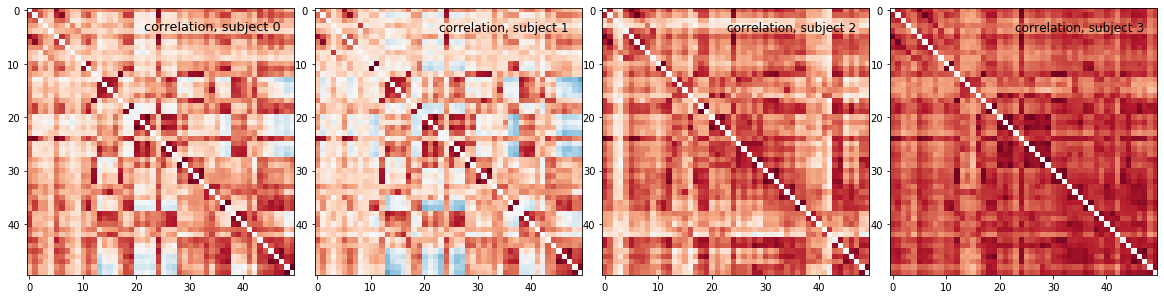

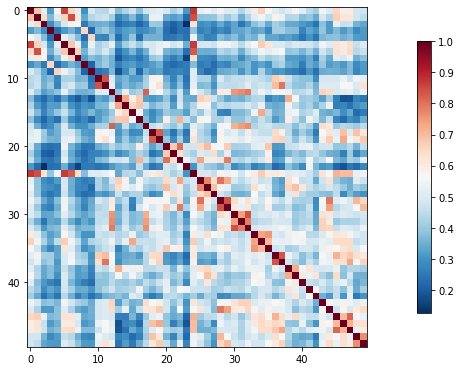

In [105]:
#load matrix plotting information
# Matrix plotting from Nilearn: nilearn.plotting.plot_matrix

def plot_matrices(matrices, matrix_kind):
    n_matrices = len(matrices)
    fig = plt.figure(figsize=(n_matrices * 4, 4))
    for n_subject, matrix in enumerate(matrices):
        plt.subplot(1, n_matrices, n_subject + 1)
        matrix = matrix.copy()  # avoid side effects
        # Set diagonal to zero, for better visualization
        np.fill_diagonal(matrix, 0)
        vmax = np.max(np.abs(matrix))
        title = '{0}, subject {1}'.format(matrix_kind, n_subject)
        plotting.plot_matrix(matrix, vmin=-vmax, vmax=vmax, cmap='RdBu_r',
                             title=title, figure=fig, colorbar=False)
        
from nilearn import plotting

plot_matrices(correlation_matrices[:4], 'correlation')
plotting.plot_matrix(mean_correlation_matrix)
#plotting.plot_connectome(mean_correlation_matrix, coordinates,
#                         edge_threshold="80%", title='MSDL (probabilistic)')

In [106]:
upper_indices = np.triu_indices(correlation_matrices.shape[-1], k=1)
correlation_matrices[:, upper_indices[0], upper_indices[1]].shape
label_data = pd.read_csv('/data/MBDU/midla/notebooks/campcc/atlas_labels.csv', header=None).values.tolist()

joined_labels = []
for ii, il in enumerate(label_data):
    for jj, jl in enumerate(label_data[(ii+1):]):
        joined_labels.append(f'{il[0]}__{jl[0]}')
cor_df = pd.DataFrame(correlation_matrices[:, upper_indices[0], upper_indices[1]], columns=joined_labels)

In [85]:
Y.mean()
# Yc = correlation_measure.fit_transform([Y])
# plotting.plot_matrix(Yc[0])

100.02291586942528

In [86]:
Z.mean()
# Zc = correlation_measure.fit_transform([Z])
# plotting.plot_matrix(Zc[0])

100.02820679729031

In [51]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
correlation_matrices[-1].view()

array([[1.        , 0.10768385, 0.10723664, 0.10711338, 0.10718826,
        0.10949469, 0.10723024, 0.10686212, 0.10673235, 0.10729584,
        0.10581147, 0.10565614, 0.10729218, 0.10392286, 0.10505615,
        0.10634448, 0.10377193, 0.10583218, 0.10783454, 0.10738671,
        0.10640846, 0.10602146, 0.10579732, 0.10253442, 0.10962913,
        0.10626004, 0.10700899, 0.10056673, 0.10690904, 0.10719585,
        0.10714364, 0.10259507, 0.10595729, 0.10782001, 0.10872142,
        0.107326  , 0.10761483, 0.10656393, 0.10692861, 0.10705893,
        0.10760011, 0.10657747, 0.10631121, 0.10790913, 0.10728336,
        0.10844676, 0.10790417, 0.10806119, 0.1078467 , 0.10744057],
       [0.10768385, 1.        , 0.10788344, 0.10679654, 0.10685004,
        0.10764515, 0.10942501, 0.10778194, 0.10731412, 0.10699102,
        0.10694771, 0.10657071, 0.1062599 , 0.1037025 , 0.10410773,
        0.10616481, 0.10318021, 0.10412678, 0.10816897, 0.10739407,
        0.10615969, 0.10514612, 0.1051418 , 0.1

In [107]:
#Calculate upper triangle indices without diagonal
#Load label data
#Append 
upper_indices = np.triu_indices(correlation_matrices.shape[-1], k=1)
correlation_matrices[:, upper_indices[0], upper_indices[1]].shape
label_data = pd.read_csv('/data/MBDU/midla/notebooks/campcc/atlas_labels.csv', header=None).values.tolist()

joined_labels = []
for ii, il in enumerate(label_data):
    for jj, jl in enumerate(label_data[(ii+1):]):
        joined_labels.append(f'{il[0]}__{jl[0]}')
cor_df = pd.DataFrame(correlation_matrices[:, upper_indices[0], upper_indices[1]], columns=joined_labels)
#cor_df.to_csv('/data/MBDU/midla/notebooks/campcc/output_data/alt_rest_upper_func_corr_matrix_121119.csv')

subj_cor_df = pd.concat([dat_paths.loc[:, ['subject', 'session', 'run']].reset_index(),cor_df],axis=1)
assert len(subj_cor_df) == len(cor_df)
subj_cor_df.to_csv('/data/MBDU/midla/notebooks/campcc/output_data/alt_rest_upper_func_corr_matrix_121119.csv')

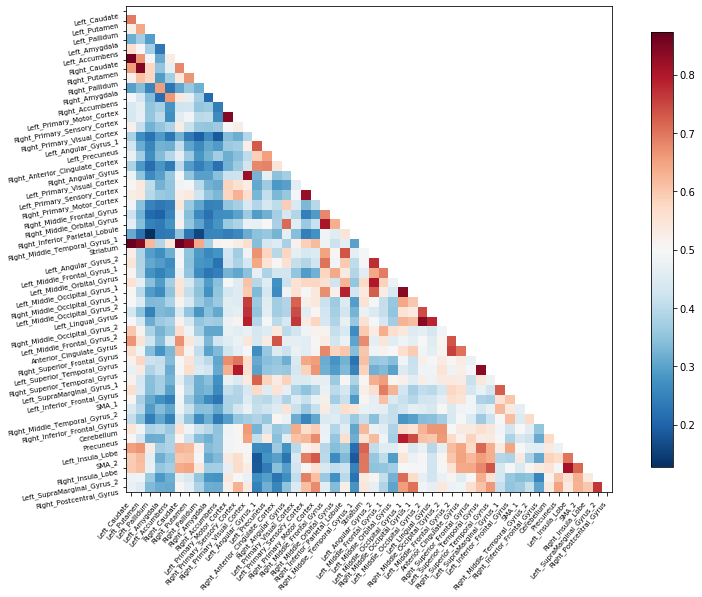

In [108]:
label_data = pd.read_csv('/data/MBDU/midla/notebooks/campcc/atlas_labels.csv', header=None).values.tolist()
labels = []
for x in label_data:
    labels.append(x[0])
upper_matrices = np.triu(correlation_matrices[0:len(correlation_matrices)],k=1)
plotting.plot_matrix(mean_correlation_matrix,labels=labels,tri='lower',figure=(10,10))

In [227]:
reorder = mean_correlation_matrix[:, label_order][label_order]

In [222]:
labels_re = [labels[i] for i in label_order]

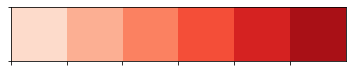

In [249]:
color = sns.palplot(sns.color_palette("Reds"))

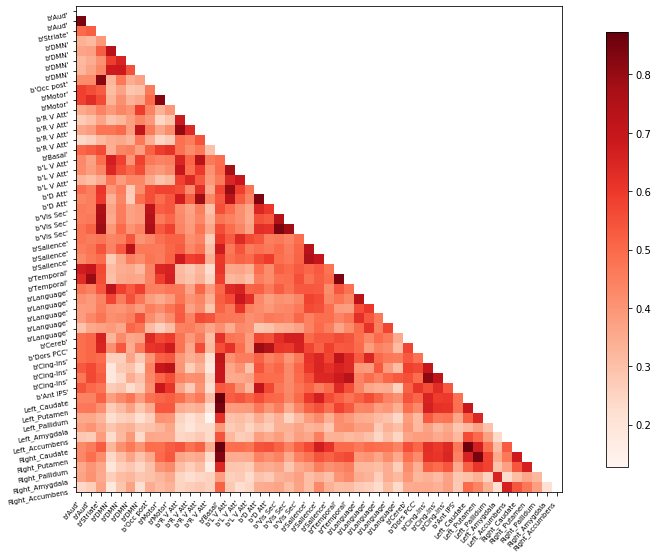

In [254]:
plotting.plot_matrix(reorder,labels=labels_re,tri='lower',figure=(10,10),cmap = 'Reds')

In [225]:
type(mean_correlation_matrix)

numpy.ndarray

In [245]:
x = 0
for label in labels_re:
    for item in msdl_dict:
        if label in msdl_dict[item]:
            labels_re[x] = item
    x+=1

In [246]:
labels_re

[b'Aud',
 b'Aud',
 b'Striate',
 b'DMN',
 b'DMN',
 b'DMN',
 b'DMN',
 b'Occ post',
 b'Motor',
 b'Motor',
 b'R V Att',
 b'R V Att',
 b'R V Att',
 b'R V Att',
 b'Basal',
 b'L V Att',
 b'L V Att',
 b'L V Att',
 b'D Att',
 b'D Att',
 b'Vis Sec',
 b'Vis Sec',
 b'Vis Sec',
 b'Salience',
 b'Salience',
 b'Salience',
 b'Temporal',
 b'Temporal',
 b'Language',
 b'Language',
 b'Language',
 b'Language',
 b'Language',
 b'Cereb',
 b'Dors PCC',
 b'Cing-Ins',
 b'Cing-Ins',
 b'Cing-Ins',
 b'Ant IPS',
 'Left_Caudate',
 'Left_Putamen',
 'Left_Pallidum',
 'Left_Amygdala',
 'Left_Accumbens',
 'Right_Caudate',
 'Right_Putamen',
 'Right_Pallidum',
 'Right_Amygdala',
 'Right_Accumbens']

In [ ]:
msdl_dict = {}
label_order = []
ua = []
ua.extend(range(49))
for x in range(38):
    for y in range(49):
        print(y)
        init = np.sum(rois_bin[:,:,:,y])
        mask = msdl_bin[:,:,:,x] * rois_bin[:,:,:,y]
        if (np.sum(mask) == init):
            label_order.append(y)
            ua.remove(y)
            if msdl_networks[x] in msdl_dict:
                msdl_dict[msdl_networks[x]].append(rois[y][0])
            else:
                msdl_dict[msdl_networks[x]] = rois[y]
                
for x in ua:
    label_order.append(x)